In [49]:
import tensorflow as tf
import pandas as  pd
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import shutil
from tensorflow.keras import layers
from tensorflow.keras import losses
import re
import string
import numpy as np

### Download the dataset

In [7]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = keras.utils.get_file("aclImdb_v1",url,untar = True , cache_dir = '.' , cache_subdir = '')

84125825/84125825 [==============================] - 15s 0us/step


In [5]:
dataset_dir =  os.path.join(os.path.dirname(dataset) , 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [6]:
train_dir = os.path.join(dataset_dir,'train')
test_dir = os.path.join(dataset_dir , "test")


# Sample
with open(os.path.join(train_dir,"pos","0_9.txt") , 'r') as f:
    print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


### Load the data

In [23]:
# Removing unwanted files

rmdir = os.path.join(train_dir,"unsup")
shutil.rmtree(rmdir)

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

In [7]:
batchSize = 32
seed = 42

print("Training Data....")
raw_train_data = keras.utils.text_dataset_from_directory( train_dir,batch_size=batchSize,
                                                         seed = seed,
                                                         shuffle=True,subset="training",validation_split=0.2)

print("\n\nValidation Data....")

raw_val_data = keras.utils.text_dataset_from_directory(train_dir , batch_size = batchSize , 
                                                       seed = seed,
                                                       shuffle = True , subset = "validation" , validation_split = 0.2)

Training Data....
Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Validation Data....
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
print("Label 0 corresponds to", raw_train_data.class_names[0])
print("Label 1 corresponds to", raw_train_data.class_names[1],"\n\n\n")


for text_batch , label_batch in raw_train_data.take(1):

    for i in range(3):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i],"\n\n")

Label 0 corresponds to neg
Label 1 corresponds to pos 



b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
0 


b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose pers

In [9]:
raw_test_data = keras.utils.text_dataset_from_directory(test_dir ,shuffle=True , batch_size= batchSize )

Found 25000 files belonging to 2 classes.


### Preprocessing the data set

Next, you will standardize, tokenize, and vectorize the data using the helpful [tf.keras.layers.TextVectorization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

In [10]:
def custom_standardizationn(ip_data):
    lowercase = tf.strings.lower(ip_data)
    stripped_html = tf.strings.regex_replace(lowercase ,'<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
    

In [16]:
max_feature = 1000
sequence_length = 250

vectorize_layer = layers.TextVectorization(standardize= custom_standardizationn , 
                                            max_tokens = max_feature , 
                                            output_mode = 'int',
                                            output_sequence_length = sequence_length)

In [17]:
train_text = raw_train_data.map(lambda x, y : x)
vectorize_layer.adapt(train_text)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_data))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_data.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"I went to see Fever Pitch with my Mom, and I can say that we both loved it. It wasn't the typical romantic comedy where someone is pining for the other, and blah blah blah... You weren't waiting for the climatic first kiss or for them to finally get together. It was more real, because you saw them through the relationship, rather than the whole movie be about them getting together. People could actually relate to the film, because it didn't seem like extraordinary circumstances, or impossible situations. It was really funny, and I think it was Jimmy Fallon's best performance. All in all... I would definitely recommend it!", shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 10, 426,   6,  67,   1,   1,  16,  54,   1,   3,  10,  68, 131,
         12,  71, 192, 446,   9,   9, 269,   2, 769, 736, 220, 114, 282,
          7,   1,  15,   2,  78,   3,   1,   1,   1,  22,   1,   1,  15,
          2,   1,  83,   1,  

In [26]:
print("10 ---> ",vectorize_layer.get_vocabulary()[10])
print("426 ---> ",vectorize_layer.get_vocabulary()[426])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

10 --->  i
426 --->  went
Vocabulary size: 1000


In [29]:
train_data = raw_train_data.map(vectorize_text)
val_data = raw_val_data.map(vectorize_text)
test_data = raw_val_data.map(vectorize_text)

### Configure the dataset for performance

In [31]:
AUTOTUNE  = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size = AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size = AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size = AUTOTUNE)

In [33]:
embedding_dims = 16

model = keras.Sequential(
[
    layers.Embedding(max_feature,embedding_dims),
    layers.Dropout(0.2) ,
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2) , 
    layers.Dense(32),
    layers.Dense(64),
 layers.Dense(1, activation='sigmoid')
]
 )

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          16000     
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                      

In [35]:
model.compile(loss= losses.BinaryCrossentropy() ,
              optimizer = 'adam' , 
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [39]:
history = model.fit(train_data , validation_data = val_data , epochs  = 10)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
620/625 [============================>.] - ETA: 0s - loss: 0.4986 - binary_accuracy: 0.7398WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000025AB90A1440> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

In [43]:
loss , score = model.evaluate(train_data)
print(loss , score)

  1/625 [..............................] - ETA: 8s - loss: 0.2933 - binary_accuracy: 0.9062

625/625 [==============================] - 1s 1ms/step - loss: 0.3192 - binary_accuracy: 0.8684
0.31920793652534485 0.8683500289916992


### Analysis

In [50]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

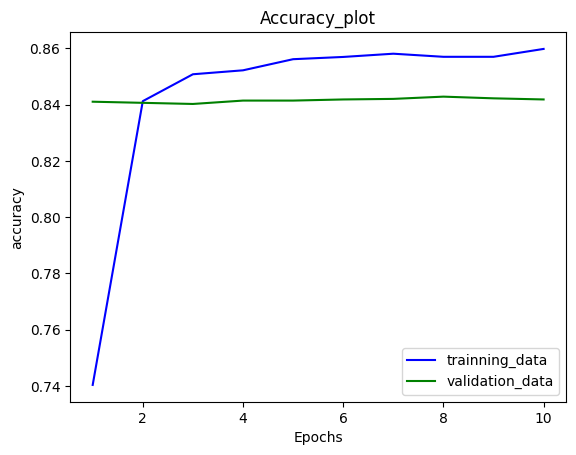

In [56]:
train_acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]

epochs  = range(1,len(train_acc) + 1)

plt.plot(epochs , train_acc , 'b' , label = "trainning_data")
plt.plot(epochs , val_acc , 'g',label = "validation_data")

plt.title("Accuracy_plot")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

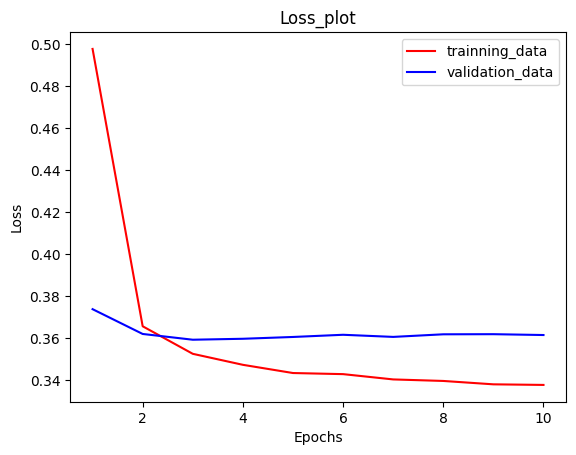

In [59]:
train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs  = range(1,len(train_loss) + 1)

plt.plot(epochs , train_loss , 'r' , label = "trainning_data")
plt.plot(epochs , val_loss , 'b',label = "validation_data")

plt.title("Loss_plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Export the model

In the code above, you applied the **TextVectorization** layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the **TextVectorization** layer inside your model. To do so, you can create a new model using the weights you just trained.

In [65]:
export_model = keras.Sequential([
    vectorize_layer ,
    model ,
    layers.Activation("sigmoid")
])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy'])

loss , acc = export_model.evaluate(raw_test_data)
print(acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

782/782 [==============================] - 7s 8ms/step - loss: 0.6008 - accuracy: 0.5001
0.5000799894332886


In [67]:
examples = tf.constant(["Movie was great",
                        "MOvie is really bad",
                        "Movie is not bad"])

export_model.predict(examples)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 133ms/step


array([[0.63921875],
       [0.58762646],
       [0.5831388 ]], dtype=float32)